In [1]:
from fit import *
import matplotlib.pyplot as plt
%matplotlib widget
from utils import plot_event, plot_generator, get_data_files, preceding_noise_file

First set up the MC configuration, i.e. the data part for which we're simulating data.

In [2]:
data_date_and_time = '20190504034237'
data_files = get_data_files(data_date_and_time)
noise_files = [preceding_noise_file(f) for f in data_files]
cfg = CounterConfig(data_files, noise_files)
ckv = GetCkv(cfg)

Now let's simulate an event with given shower parameters.

In [3]:
pars = [600.,2.e6,np.deg2rad(40.),np.deg2rad(315.), 450., -660.,-25.25,0,70,80.]
ev = BasicParams.get_event(pars)
pe = ProcessEvents(cfg, frozen_noise=True)
real_nfits = pe.gen_nfits_from_event(ev)
print(ev)

Event(E=1538461538461538.5, Xmax=600.0, Nmax=2000000.0, zenith=0.6981317007977318, azimuth=5.497787143782138, corex=450.0, corey=-660.0, corez=-25.25, X0=0, Lambda=70)


We now have fitted NICHE waveforms, so we can estimate the core position with a tyro fit, and perform a plane fit to estimate the shower direction. We then compile this info into inital guesses to supply to the minimizer.

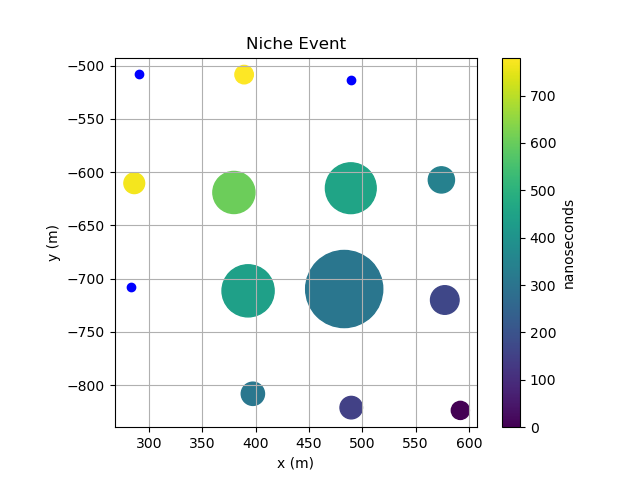

In [4]:
ty = tyro(real_nfits)
pf = NichePlane(real_nfits)
plot_event(ty)

In [5]:
pf

20240312160533.000025477
bell curie dirac feynman meitner newton noether rossi rubin rutherford yukawa 
nx =  0.4458 ny = -0.5065 z0 =   5.1
  +/- 0.0002   +/- 0.0002   +/-  0.0
  ( 4.51e-08  5.43e-09 -3.71e-07)
  ( 5.43e-09  4.95e-08  2.77e-07)
  (-3.71e-07  2.77e-07  7.16e-05)
th =  0.7406 ph =  5.4341

In [6]:
guess = make_guess(ty, pf,cfg)
for i,p in enumerate(guess):
    guess[i].value = pars[i]
[print(p) for p in guess];

FitParam(name='xmax', value=600.0, limits=(400.0, 800.0), error=50.0, fixed=False)
FitParam(name='nmax', value=2000000.0, limits=(10000.0, 100000000.0), error=100000.0, fixed=False)
FitParam(name='zenith', value=0.6981317007977318, limits=(0.0, 0.8405623456804957), error=0.017453292519943295, fixed=False)
FitParam(name='azimuth', value=5.497787143782138, limits=(5.3341115516105795, 5.534111551610579), error=0.017453292519943295, fixed=False)
FitParam(name='corex', value=450.0, limits=(379.5, 489.2), error=5.0, fixed=False)
FitParam(name='corey', value=-660.0, limits=(-711.4, -615.1), error=5.0, fixed=False)
FitParam(name='corez', value=-25.25, limits=(-25.25, -25.25), error=1.0, fixed=True)
FitParam(name='x0', value=0, limits=(0, 0), error=1, fixed=True)
FitParam(name='lambda', value=70, limits=(70.0, 70.0), error=1, fixed=True)
FitParam(name='t_offset', value=80.0, limits=(-150.0, 150.0), error=10.0, fixed=False)


Fitting for the log of xmax and nmax rather than the values themselves results in a better fit, so we use the BasicParams mapper to go between the fitted parameters and the real ones.

In [7]:
guess = BasicParams.adjust_guess(guess)
# guess = pars

In [8]:
at = AllSamples(real_nfits, BasicParams, cfg)
at.target_parameters = ['t_offset']
m = init_minuit(at, guess)
# m.migrad()

In [9]:
m.tol=.1
m.fixed = True
m.fixed['xmax'] = False
m.fixed['nmax'] = False
m.fixed['zenith'] = False
m.fixed['azimuth'] = False
m.fixed['corex'] = False
m.fixed['corey'] = False
m.fixed['t_offset'] = False

/home/isaac/anaconda3/envs/py10/lib/python3.10/site-packages/iminuit/minuit.py:2474: IMinuitWarning: Specified nsigma bound, but error matrix is not accurate
  warnings.warn(


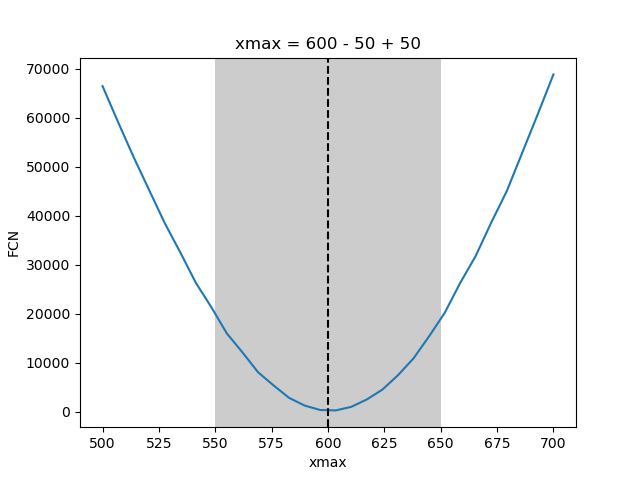

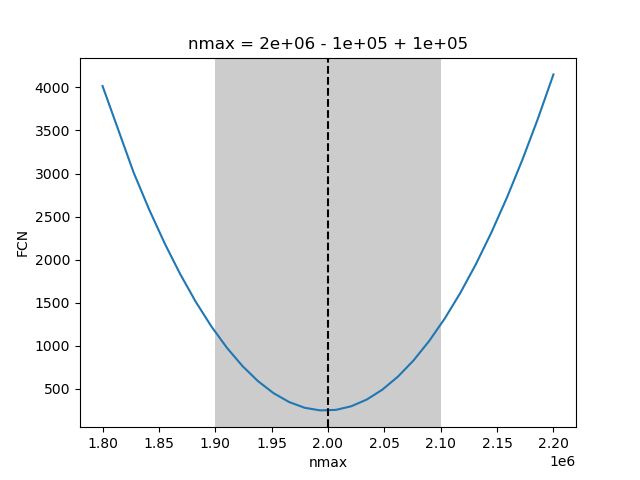

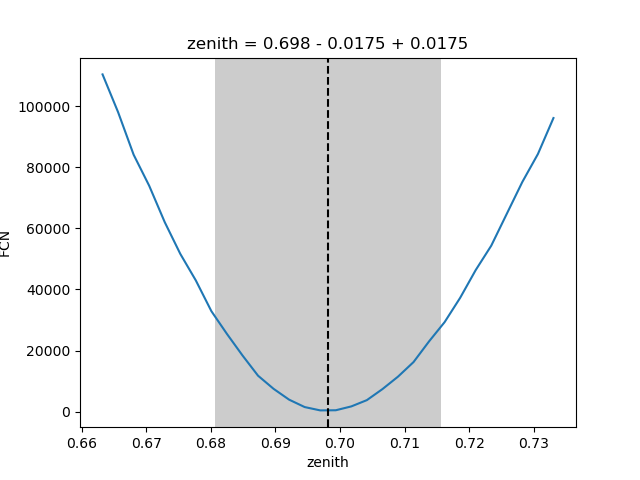

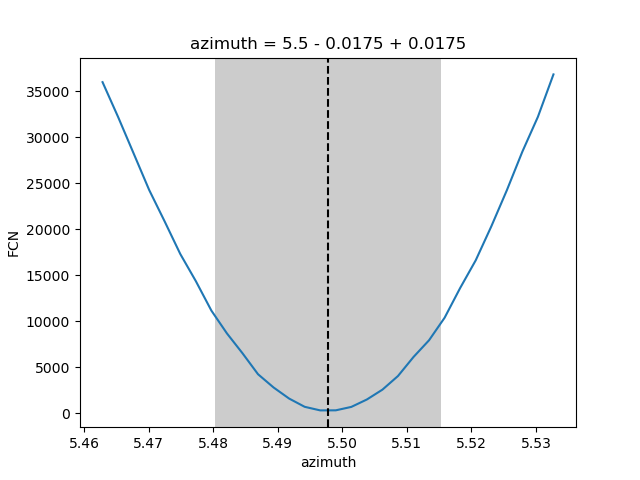

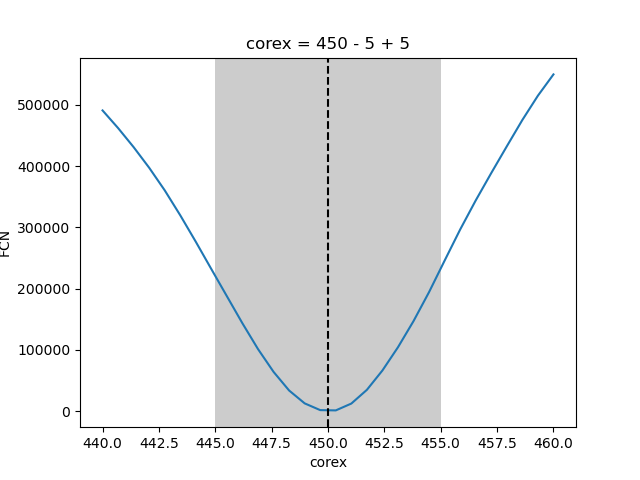

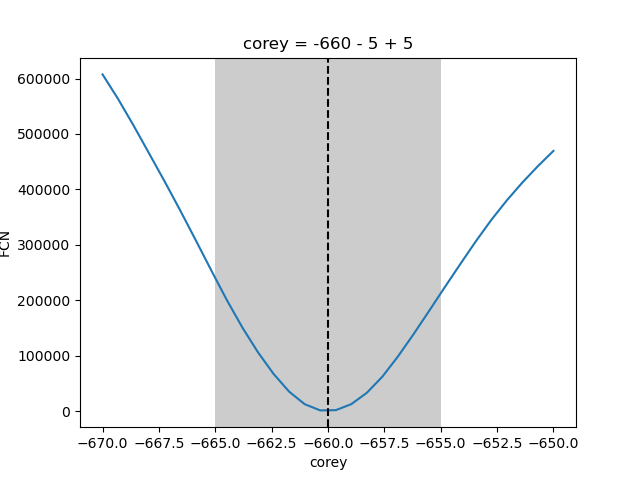

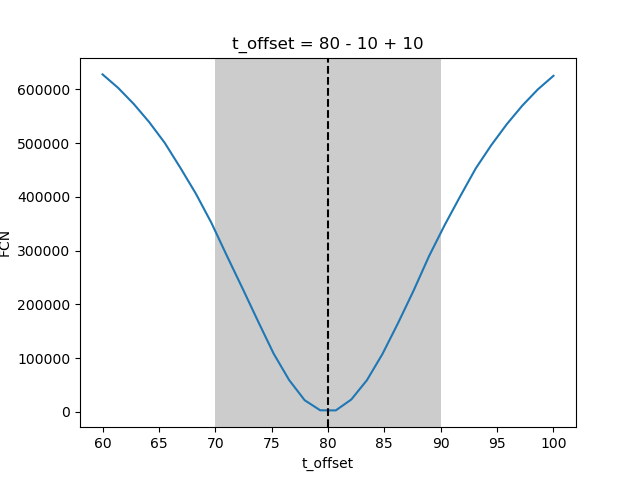

In [10]:
parnames = np.array([p.name for p in m.params])[~m.fixed]
for name in parnames:
    plt.figure()
    m.draw_profile(name, subtract_min=False, size = 30)
    # m.draw_profile(name, bound=m.limits[name], subtract_min=False)